In [2]:
!pip install datasets
!pip install clean-text
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.8 MB/s eta 0:

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import re
import nltk
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Dataset

In this part we read the dataset and we plot the distributions of the labels and the length of all the texts. 
We are dealing with a small dataset containing conspiratorial texts.

In [4]:
dataset = pd.read_csv("../datasets/subtaskA_train.csv")
dataset = dataset.drop('Id', axis=1)
dataset = dataset.rename(columns={'comment_text': 'text', 'conspiratorial': 'label'})
dataset

,text,label
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0
...,...,...
1837,avvolge la terra spesso 2000 km Oooh mi ricor...,1
1838,Comunque le recensioni erano negative ancora p...,0
1839,Intanto in Kazakistan la gente che ne ha le pa...,1
1840,Una profezia ad una conferenza del 2015:\nIl p...,1


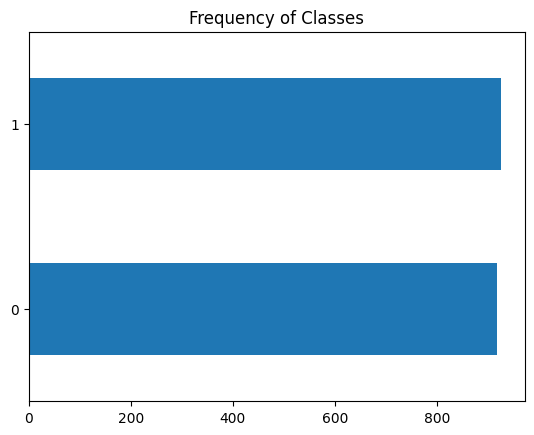

In [ ]:
dataset['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

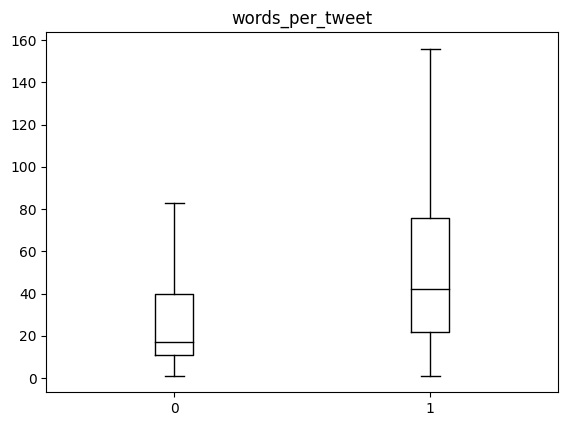

In [ ]:
dataset['words_per_tweet'] = dataset['text'].str.split().apply(len)
dataset.boxplot('words_per_tweet', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

dataset = dataset.drop('words_per_tweet', axis=1)

# Text Cleaning

In this section, first of all, we define the function that we will use to clean our text. As we can se above there are some texts between parentesis that are usefull and also unicodes.
We are removing all that stuff creating a text that is similar to the ones used to train the pre-trained model. So, for instance, we won't remove the punctuation and and stopwords.

In [5]:
# We define the function for the cleaning of the text

def text_cleaning(text):
    # Convert words to lower case
    text = text.lower()
    text = clean(text, no_emoji=True)

    text = re.sub(r'(\[.*?\])', '', text)
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{2,4}', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'[_"\%()|+&=*%#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\.+','.', text)
    text = re.sub(r'\,+',',', text)
    text = re.sub(r'\!+','!', text)
    text = re.sub(r'\?+','?', text)
    text = re.sub(r'\n+','', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    return text

In [6]:
dataset['text'] = list(map(text_cleaning, dataset.text))
dataset

,text,label
0,se non ci fossero soldati non ci sarebbero gue...,0
1,shedding of infectious sars-cov-2 despite vac...,1
2,paura e delirio alla cnn: il ministero della v...,1
3,l'aspirina non aumenta la sopravvivenza dei pa...,0
4,l'italia non puo' dare armi lo vieta la costit...,0
...,...,...
1837,avvolge la terra spesso 2000 km oooh mi ricord...,1
1838,comunque le recensioni erano negative ancora p...,0
1839,intanto in kazakistan la gente che ne ha le pa...,1
1840,una profezia ad una conferenza del 2015:il pro...,1


# Model download

In this part we are downloading the bert-model and it's tokenizer from the hugging face hub.
In that specific case we will use the bert multilingual model

In [7]:
model_name = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [9]:
# We controll if the device support the computation on the GPU, otherwise we will compute the model on the CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = 2  # Number of classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

## Metrics
We define the metric that we want to calculate during the fine-tuning of the model

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1_score': f1}

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [12]:
def createDataset(train, val):
  tds = Dataset.from_pandas(train)
  vds = Dataset.from_pandas(val)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = tds
  dataset_hf['validation'] = vds
  dataset_hf['train']= dataset_hf['train'].remove_columns("__index_level_0__")
  dataset_hf['validation']= dataset_hf['validation'].remove_columns("__index_level_0__")

  return dataset_hf

In [13]:
# Define a custom collator function with dynamic masking
def collate_fn(batch):
    input_ids = [example['input_ids'] for example in batch]
    labels = [example['label'] for example in batch]

    # Apply dynamic masking
    for i in range(len(input_ids)):
        # Generate a random mask
        mask = [0] * len(input_ids[i])
        for j in range(len(input_ids[i])):
            if random.random() < 0.15:
                mask[j] = 1

        # Apply the mask to the input sequence
        input_ids[i] = [input_ids[i][j] if not mask[j] else tokenizer.mask_token_id for j in range(len(input_ids[i]))]

    # Pad the input sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(input_ids[i]) for i in range(len(input_ids))],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create the input dictionary
    inputs = {'input_ids': input_ids, 'attention_mask': input_ids != tokenizer.pad_token_id, 'labels': torch.tensor(labels)}

    return inputs

## Cross-Validation

Now we will define the cross validation to find the best hyperparameters of the model. This since we have a very small dataset, so we are trying to generalize as much as possible.

In [15]:
import random

lr_rates = [2e-5, 3e-5]
epochs = [2,3,4]
lr_scheduler = ['constant']

log_results_cross = pd.DataFrame({
    'learning_rate': [],
    'epochs': [],
    'f1_score': [],
    'lr_scheduler': []
})

for lr in lr_rates:
  for epoch in epochs:
    for scheduler in lr_scheduler:
      results = []

      for i in range(5):
        # We create the split of the dataset, shuffling before the data
        train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
        df = createDataset(train, val)
        texts_encoded = df.map(tokenize, batched=True, batch_size=None)

        # We define the argument that the model has to use
        batch_size = 8
        logging_steps = len(texts_encoded['train'])
        model_name_hub = f'{model_name}-kcross'
        training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=epoch,
                                    learning_rate=lr,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    #lr_scheduler_type=scheduler,
                                    fp16=True,
                                    push_to_hub=False,
                                    log_level='error')
        # Train of the model
        trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=texts_encoded['train'],
                    eval_dataset=texts_encoded['validation'],
                    data_collator=collate_fn,
                    tokenizer=tokenizer)
        trainer.train()
        results.append(trainer.predict(texts_encoded['validation']).metrics['test_f1_score'])
    
    # We calculate the mean of the f1_scores and we save the model and the result on a log
    mean_f1_score = sum(results) / len(results)
    print(mean_f1_score)

    # We log the actual parameters and the mean f1_score
    parameters = [lr, epoch, mean_f1_score, scheduler]
    log_results_cross.loc[len(log_results_cross)] = parameters
  
log_results_cross.to_csv('/log/log_dynamic_2.csv')

Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.565249,0.731229
2,No log,0.496846,0.766968


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.540497,0.761444
2,No log,0.533675,0.774998


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.867782,0.758762
2,No log,0.995180,0.753442


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.414944,0.747319
2,No log,1.350736,0.779983


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.766897,0.720436
2,No log,1.582898,0.753406


0.7549584543158231


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.061197,0.750105
2,No log,1.484478,0.745291
3,No log,1.421569,0.753279


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.969501,0.753159
2,No log,1.599950,0.745628
3,No log,1.719277,0.736292


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.656527,0.758187
2,No log,1.724907,0.788664
3,No log,1.966248,0.745179


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.206882,0.753476
2,No log,1.549496,0.782204
3,No log,1.904362,0.756151


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.219567,0.773129
2,No log,1.745460,0.775389
3,No log,1.918302,0.763749


0.7468310023657667


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.087095,0.764432
2,No log,1.925714,0.771231
3,No log,2.222951,0.754007
4,No log,1.309998,0.791328


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.949564,0.780488
2,No log,1.897359,0.753438
3,No log,2.056130,0.755664
4,No log,1.703758,0.802020


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.271227,0.748019
2,No log,1.850190,0.802209
3,No log,2.166733,0.755990
4,No log,1.906723,0.788553


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.600667,0.742635
2,No log,2.055512,0.785955
3,No log,1.924986,0.794074
4,No log,1.701670,0.799485


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.985546,0.785952
2,No log,2.250756,0.781339
3,No log,1.776368,0.799234
4,No log,1.949739,0.780517


0.8090707398146074


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.491960,0.698185
2,No log,1.641776,0.796596


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.677274,0.729013
2,No log,1.828557,0.791051


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.937089,0.793766
2,No log,2.020051,0.796521


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.926347,0.779128
2,No log,1.885804,0.796763


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.947517,0.804861
2,No log,1.764053,0.788011


0.7859996696708531


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.045316,0.791328
2,No log,1.938437,0.787877
3,No log,2.018493,0.766979


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.967026,0.755538
2,No log,1.425178,0.749894
3,No log,1.658965,0.760833


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.786242,0.784581
2,No log,1.066011,0.826482
3,No log,1.485166,0.763478


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.800607,0.799440
2,No log,1.391030,0.781848
3,No log,1.437172,0.775068


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.577051,0.781439
2,No log,1.251971,0.771835
3,No log,1.414817,0.785814


0.7741175738834228


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.096881,0.779644
2,No log,1.217441,0.812578
3,No log,1.896866,0.774850
4,No log,1.496956,0.790211


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.872338,0.794038


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.872338,0.794038
2,No log,1.361793,0.793947
3,No log,2.033874,0.749649
4,No log,1.626506,0.796336


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.325048,0.772398
2,No log,1.752010,0.796596
3,No log,1.703053,0.739493
4,No log,1.544662,0.785814


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.843864,0.782955
2,No log,1.897772,0.768881
3,No log,1.720745,0.750696
4,No log,1.557490,0.794080


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.414764,0.782862
2,No log,2.071233,0.794080
3,No log,2.115918,0.780527
4,No log,2.012438,0.791263


0.8006755751031911


# Train final Model

Now that we finished the cross-validation, we take the best model found and we buil the final model.
Then, we push the model into the hugging face hub

In [16]:
train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
dataset_final_train = createDataset(train, val)
dataset_final_encoded = dataset_final_train.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

In [17]:
# We take the best parameter from the log
idx_best_model = log_results_cross['f1_score'].idxmax()
learning_rate_best = log_results_cross['learning_rate'][idx_best_model]
epoch_best = float(log_results_cross['epochs'][idx_best_model])
#lr_scheduler_best = log_results_cross['lr_scheduler'][idx_best_model]

# We define the arguments for the training 
batch_size = 8
logging_steps = len(dataset_final_encoded['train'])
model_name_hub = 'prova-multi-single-2'

# We train the final model
training_args = TrainingArguments(output_dir=model_name_hub,
                                  num_train_epochs=epoch_best,
                                  learning_rate=learning_rate_best,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #lr_scheduler_type=lr_scheduler_best,
                                  fp16=True,
                                  push_to_hub=True,
                                  log_level='error')

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_final_encoded['train'],
                  eval_dataset=dataset_final_encoded['validation'],
                  data_collator=collate_fn,
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

Cloning https://huggingface.co/Mike00vito/prova-multi-single-2 into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,3.373114,0.754250
2,No log,3.156858,0.762326
3,No log,3.195399,0.760833
4,No log,3.047496,0.773471


Upload file pytorch_model.bin:   0%|          | 1.00/638M [00:00<?, ?B/s]

Upload file runs/May06_18-56-49_532d29254540/events.out.tfevents.1683399414.532d29254540.240.62:   0%|        …

To https://huggingface.co/Mike00vito/prova-multi-single-2
   5b2d601..0f44db7  main -> main

   5b2d601..0f44db7  main -> main

To https://huggingface.co/Mike00vito/prova-multi-single-2
   0f44db7..6a77947  main -> main

   0f44db7..6a77947  main -> main



'https://huggingface.co/Mike00vito/prova-multi-single-2/commit/0f44db7294518e6ebe1620957e60b9199baec4c5'